In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#%matplotlib
from matplotlib.pyplot import cm

In [2]:
from pathlib import Path
folder='./Helper_scripts/'

importLibs=1
for path in Path(folder).rglob('*.py'):
    print(path.name)
    exec(open(path).read())

FFT.py
GetFrequencyFromZCfile.py
importLibs0.py
VariablesExperiment.py
parseCC.py
DisplayAndCut.py


In [3]:
VariablesExperiment(20210527)
# 20210527 Decreasing rotor speed

In [4]:
scope_dat

,Unnamed: 0,Index1,Date,Description0,Part,Description1,SerialFile,ScopeFile,Symbol,CalcByPy,2Tex,Value,Unit,Unnamed: 13
0,78,79,20210527,Aufnahme,scope,"36,37",../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_37_1.csv,parallel,NaN,NaN,29.5,Hz,NaN
1,79,80,20210527,Aufnahme,scope,38,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_38_1.csv,parallel,NaN,NaN,29.5,Hz,NaN
2,80,81,20210527,Aufnahme,scope,39,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_39_1.csv,parallel,NaN,NaN,29.5,Hz,NaN
3,81,82,20210527,Aufnahme,scope,40,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_40_1.csv,parallel,NaN,NaN,29.5,Hz,NaN
4,82,83,20210527,Aufnahme,scope,41,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_41_1.csv,parallel,NaN,NaN,29.5,Hz,NaN
5,85,86,20210527,Aufnahme,scope,"42,43",../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_42_1.csv,Rotor_Deviated,mit Auslauf,NaN,28.5,Hz,NaN
6,86,87,20210527,Aufnahme,scope,44,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_44_1.csv,Rotor_Deviated,NaN,NaN,27.9,Hz,NaN
7,87,88,20210527,Aufnahme,scope,45,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_45_1.csv,Rotor_Deviated,NaN,NaN,28.5,Hz,NaN
8,88,89,20210527,Aufnahme,scope,46,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_46_1.csv,Rotor_Deviated,NaN,NaN,28.4,Hz,NaN
9,89,90,20210527,Aufnahme,scope,47,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_47_1.csv,Rotor_Deviated,mit Auslauf,NaN,28.4,Hz,NaN


# Definition of functions
* read scope data of 1 revolution
* create vector p from u1 (sig1) and u2 (sig2)  p=u1+1j*u2
* compute rotor rotation angle (approx.) by integration of the vector angle
* calculate velocity regression of vector p length and time
* normalize u1
* compute fourier transformation of u1 with angle of p

In [5]:
def read_file_complex(file0,ti,tf,f1):
    row=scope_dat.loc[1]
    scope=pd.read_csv(file0,sep=",",skiprows=[0],names=['time','sig1'],header=0)
    scope=scope[::f1]
    filter=(scope['time']>ti)&(scope['time']<tf)
    u1=scope.loc[filter,'sig1'].to_numpy(copy=True)
    time=(scope.loc[filter,'time'].to_numpy(copy=True))-ti
    file1=file0.replace("1.csv","2.csv")
    scope=pd.read_csv(file1,sep=",",skiprows=[0],names=['time','sig1'],header=0)
    u2=(-1)*scope.loc[filter,'sig1'].to_numpy(copy=True)
    p=u1+1j*u2
    return p,time
    #pole_count=angle.copy()
    
def filter_values(p,t):
    angle_diff=np.diff(np.angle(p))
    a=p.size
    filterA=(angle_diff<0.0)
    filterB=(angle_diff>-0.01)
    filter=filterA & filterB
    filter1=np.append(filter,True)
    p=p[filter1].copy()
    time=t[filter1].copy()
    print("reduziert von "+ str(a/1000) + " Tsd auf "+ str(p.size/1000)+" Tsd, davon >0: " + str(angle_diff[(angle_diff>0.0)].size))
    plt.plot(angle_diff)
    return p,time

def sum_angle(p):
    angle_diff=np.diff(np.angle(p))
    x=np.zeros(p.size)
    b=0;c=0;firstPi=True;firstPi_offset=0.0
    for i,a in enumerate(angle_diff):
        if(a>5):
            a=(angle_diff[i-1]+angle_diff[i+1])/2
            c+=1
            if(firstPi):
                firstPi=False
                firstPi_offset=b
        b=a+b
        x[i+1]=b
    x=x-firstPi_offset
    print("Anzahl Sprünge von +/- Pi: " + str(c))
    return x,c

#nsoll = Anz Pole
def filter_turns(p,time,x,n_soll0):
    n_soll=2*n_soll0
    n=x.min()//(np.pi)
    #Erkenne erste positive Halbwelle
    a=np.abs(p)[(x<(-1*np.pi))]
    n_start=2
    if((a[40]-a[0])>0):n_start=1
    print("Anzahl Pole: "+ str(-n/2), "gekürzt auf: "+ str(n_soll/2))
    if(n>(n_soll-1)): print(Vorsicht)
    filter=(x<(-1*(n_start)*np.pi)) & (x>((-1*(n_start+n_soll)*np.pi)))
    time1=time[filter].copy()
    time1=time1-time1.min()                                   
    p1=p[filter].copy()
    x1=x[filter].copy()
    x1=x1-x1.max()
    return(p1,time1,x1)    


def velocity_regression(time,p):
    z = np.polyfit(time, np.abs(p), 2)
    return(z)

#read scope file and keep data of 1 revolution
def read_file_c1(file):
    nimm=1
    p0,time0=read_file_complex(file,4.0,5.0,nimm) #0.2 0.8, Aufnahmelänge 5sek
    x0,c=sum_angle(p0)
    #print("Size nicht gefiltert: "+str(p0.size/1000)+ "Tsd")
    p1,time1,x1=filter_turns(p0,time0,x0,12)    # 12 poles = 1 revolution
    print("Size 1 revolution: "+str(p1.size/1000)+ "k")
    return(p1,time1,x1)

In [6]:
K=np.arange(0,40,0.01) #Frequency spectrum index
y=np.zeros([scope_dat.shape[0],K.size],dtype = 'complex_') #array results FT
y_u=y.copy()
u_rms_vektor=np.zeros([scope_dat.shape[0]])
u_rms_u1=np.zeros([scope_dat.shape[0]])
velocity_poly=np.zeros([scope_dat.shape[0],3]) #array velocity regression

## Calculate URMS


In [7]:
if(True):
    for index, row in scope_dat.iterrows():
        print(str(index),row['Symbol'])
        p0,time0,x0=read_file_c1(row['ScopeFile'])
        velocity_poly[index]=velocity_regression(time0,p0)
        reg = np.poly1d(velocity_poly[index])
        reg_val=reg(time0)
        urms0=np.sqrt(((np.abs(p0)/reg_val)**2).sum()/p0.size)
        u_rms_vektor[index]=urms0
        urms0=np.sqrt(((np.real(p0)/reg_val)**2).sum()/p0.size)
        u_rms_u1[index]=urms0

    
    

0 parallel
Anzahl Sprünge von +/- Pi: 27
Anzahl Pole: 27.0 gekürzt auf: 12.0
Size 1 revolution: 44.128k
1 parallel
Anzahl Sprünge von +/- Pi: 27
Anzahl Pole: 27.0 gekürzt auf: 12.0
Size 1 revolution: 44.122k
2 parallel
Anzahl Sprünge von +/- Pi: 27
Anzahl Pole: 26.5 gekürzt auf: 12.0
Size 1 revolution: 44.101k
3 parallel
Anzahl Sprünge von +/- Pi: 27
Anzahl Pole: 27.0 gekürzt auf: 12.0
Size 1 revolution: 44.046k
4 parallel
Anzahl Sprünge von +/- Pi: 27
Anzahl Pole: 27.0 gekürzt auf: 12.0
Size 1 revolution: 44.119k
5 Rotor_Deviated
Anzahl Sprünge von +/- Pi: 25
Anzahl Pole: 24.5 gekürzt auf: 12.0
Size 1 revolution: 48.193k
6 Rotor_Deviated
Anzahl Sprünge von +/- Pi: 24
Anzahl Pole: 24.0 gekürzt auf: 12.0
Size 1 revolution: 48.656k
7 Rotor_Deviated
Anzahl Sprünge von +/- Pi: 25
Anzahl Pole: 25.0 gekürzt auf: 12.0
Size 1 revolution: 47.477k
8 Rotor_Deviated
Anzahl Sprünge von +/- Pi: 24
Anzahl Pole: 24.0 gekürzt auf: 12.0
Size 1 revolution: 48.279k
9 Rotor_Deviated
Anzahl Sprünge von +/- 

### The Ellipse


In [8]:
scope_dat.iloc[[0,1]]

,Unnamed: 0,Index1,Date,Description0,Part,Description1,SerialFile,ScopeFile,Symbol,CalcByPy,2Tex,Value,Unit,Unnamed: 13
0,78,79,20210527,Aufnahme,scope,"36,37",../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_37_1.csv,parallel,NaN,NaN,29.5,Hz,NaN
1,79,80,20210527,Aufnahme,scope,38,../measurement_data/20210527/ZC/Lines_20210527...,../measurement_data/20210527/scope/scope_38_1.csv,parallel,NaN,NaN,29.5,Hz,NaN


Anzahl Sprünge von +/- Pi: 27
Anzahl Pole: 27.0 gekürzt auf: 12.0
Size 1 revolution: 44.122k
Anzahl Sprünge von +/- Pi: 25
Anzahl Pole: 24.5 gekürzt auf: 12.0
Size 1 revolution: 48.193k


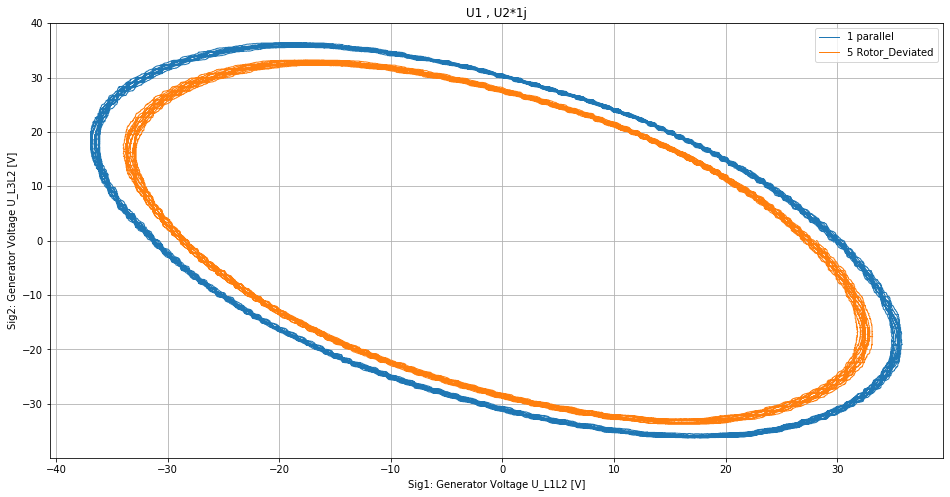

In [9]:
if(True):
    s=0.8
    fig, ax0 = plt.subplots(1,1,figsize = (s*20,s*10))
    for i, row in scope_dat.iloc[[1,5]].iterrows():
        p0,time0,x0=read_file_c1(row['ScopeFile'])
        ax0.plot(np.real(p0),np.imag(p0), label=str(i)+" "+row['Symbol'],linewidth=1)
    ax0.grid(True)
    ax0.set_title("U1 , U2*1j")
    ax0.set_xlabel('Measurement Number')
    ax0.set_xlabel('Sig1: Generator Voltage U_L1L2 [V]')
    ax0.set_ylabel('Sig2: Generator Voltage U_L3L2 [V]')
    plt.legend()
    #plt.savefig("u_Rotorauslenkung_ndec_u1u2.png",dpi=600)

### Regression Polynominals
* https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
* Calculate Polynominals y=p0+p1*x+p2*x**2


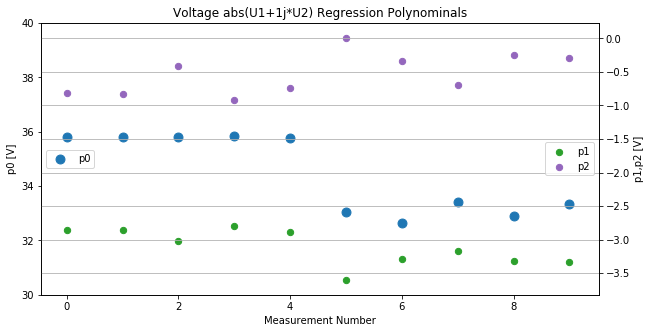

In [10]:
if(True):
    #color = cm.rainbow(np.linspace(0, 1, 10))
    s=1
    fig, ax0 = plt.subplots(1,1,figsize = (s*10,s*5))
    ax1=ax0.twinx()
    for i, row in scope_dat.iterrows():
        if(row['Symbol']=='parallel'): color='C0'
        else: color='C1'
        if(i==9): label0='p0';label1='p1';label2='p2';
        else: label0=label1=label2=None;
        ax0.scatter(i,velocity_poly[i,2],label=label0, color='C0', s=80)
        ax1.scatter(i,velocity_poly[i,1],label=label1, color='C2',s=40)
        ax1.scatter(i,velocity_poly[i,0],label=label2, color='C4',s=40)
    ax0.set_ylim(30,40)
    #ax0.set_ylim(-10,40)
    ax1.grid(True)
    ax0.set_title("Voltage abs(U1+1j*U2) Regression Polynominals")
    ax0.set_xlabel('Measurement Number')
    ax0.set_ylabel('p0 [V]')
    ax1.set_ylabel('p1,p2 [V]')
    ax0.legend(loc=6)
    ax1.legend(loc=5)
    #plt.savefig("u_Rotorauslenkung_ndec_u1u2.png",dpi=600)
    plt.show()

### Measured U_rms 
* The normalized voltage is multiplied by 24.0 V (rated Voltage)

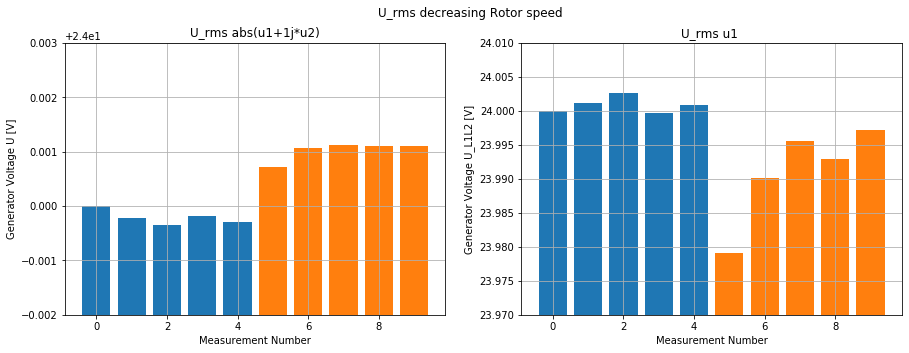

In [11]:
if(True):
    #color = cm.rainbow(np.linspace(0, 1, 10))
    s=1
    fig, ax = plt.subplots(1,2,figsize = (s*15,s*5))
    ax0=ax[0]
    ax1=ax[1]
    for i, row in scope_dat.iterrows():
        if(row['Symbol']=='parallel'): color='C0'
        else: color='C1'
        ax0.bar(i,u_rms_vektor[i]/u_rms_vektor[0]*24.0,label=row['Symbol'], color=color)
        ax1.bar(i,u_rms_u1[i]/u_rms_u1[0]*24.0,label=row['Symbol'], color=color)
    ax0.set_ylim(23.998,24.003)
    ax1.set_ylim(23.970,24.01)
    ax0.grid(True)
    ax1.grid(True)
    fig.suptitle("U_rms decreasing Rotor speed")
    ax0.set_title("U_rms abs(u1+1j*u2)")
    ax1.set_title("U_rms u1 ")
    ax0.set_xlabel('Measurement Number')
    ax1.set_xlabel('Measurement Number')
    ax0.set_ylabel('Generator Voltage U [V]')
    ax1.set_ylabel('Generator Voltage U_L1L2 [V]')
    #plt.legend(loc=6)
    plt.savefig("u_Rotorauslenkung_ndec_u1u2.png",dpi=600)
    plt.show()